# DeltaSVM data underlying the Kircher _et al_ (2019) ROC benchmarks

For comparing the accuracy of BlueSTARR, We aim to reuse the data underlying the deltaSVM ROC scores in the [Kircher _et al_ (2019)](https://doi.org/10.1038/s41467-019-11526-w) MPRA study.

## Setup

### Imports

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import duckdb
from pathlib import Path
import sys
sys.path.append('..')

### Paths to data and databases

In [2]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
DATA_DIR = PROJECT_ROOT / 'benchmarks'
MPRA_DATA_DIR = DATA_DIR / 'Kircher_et_al_2019'
GKSVM_DATA_DIR = DATA_DIR / 'Kircher_et_al_2019-gksvm'

## Read and wrangle data

### Read MPRA data from Kircher _et al_ (2019)

We need these so we can align, map, and label the deltaSVM scores.

In [3]:
from starrutil.mprautil import read_kircher_mpra_data, get_kircher_mpra_regions
mpra_data = read_kircher_mpra_data(MPRA_DATA_DIR)
mpra_regions = get_kircher_mpra_regions(mpra_df=mpra_data)

### Read, align, and map deltaSVM data from Kircher _et al_ (2019)

The raw data use relative positions, and as it turns out, some re

In [4]:
from starrutil.mprautil import read_kircher_gksvm_data, map_to_mpra_region
gksvm_proc = read_kircher_gksvm_data(GKSVM_DATA_DIR)
gksvm_aligned = map_to_mpra_region(gksvm_proc, mpra_data, verbose=True)

Region 'MYCrs11986220' found in forward orientation.
Region 'MYCrs11986220' has gaps in the alignment.
	Removing gap 107:108 (1 base(s)).
	Re-enumerating relative positions >= 108.
Region 'MYCrs11986220' has initial offset 20, adjusting relative positions.
Region 'MYCrs6983267' found in forward orientation.
Region 'MYCrs6983267' has no gaps in alignment.
Region 'MYCrs6983267' has initial offset 20, adjusting relative positions.
Region 'SORT1' found in forward orientation.
Region 'SORT1' has no gaps in alignment.
Region 'SORT1' has initial offset 20, adjusting relative positions.
Region 'F9' found in forward orientation.
Region 'F9' has no gaps in alignment.
Region 'F9' has initial offset 20, adjusting relative positions.
Region 'FOXE1' found in forward orientation.
Region 'FOXE1' has no gaps in alignment.
Region 'FOXE1' has initial offset 20, adjusting relative positions.
Region 'HNF4A' found in forward orientation.
Region 'HNF4A' has no gaps in alignment.
Region 'HNF4A' has initial of

### Sources of redundancies in deltaSVM predictions

#### Which assay (or experiment) is used for which region?

There are 3 different assays associated with the predictions, but only one of them (`DukeDnase`) has predictions for each of the 10 regions.

By assay (or experiment):

In [5]:
duckdb.sql("select experiment, count(distinct region) as num_regions, group_concat(distinct region) as regions "
           "from gksvm_aligned group by experiment order by experiment")


┌────────────┬─────────────┬─────────────────────────────────────────────────────────────────────┐
│ experiment │ num_regions │                               regions                               │
│  varchar   │    int64    │                               varchar                               │
├────────────┼─────────────┼─────────────────────────────────────────────────────────────────────┤
│ DHS_H3Kme1 │           4 │ SORT1,F9,LDLR,PKLR                                                  │
│ DukeDnase  │          10 │ MYCrs11986220,HNF4A,MSMB,TERT,SORT1,FOXE1,MYCrs6983267,LDLR,PKLR,F9 │
│ UwDnase    │           6 │ F9,LDLR,PKLR,SORT1,FOXE1,MYCrs11986220                              │
└────────────┴─────────────┴─────────────────────────────────────────────────────────────────────┘

By region:

In [6]:
duckdb.sql("select region, count(distinct experiment) as num_experiments, group_concat(distinct experiment) as experiments "
           "from gksvm_aligned group by region order by region")


┌───────────────┬─────────────────┬──────────────────────────────┐
│    region     │ num_experiments │         experiments          │
│    varchar    │      int64      │           varchar            │
├───────────────┼─────────────────┼──────────────────────────────┤
│ F9            │               3 │ DHS_H3Kme1,DukeDnase,UwDnase │
│ FOXE1         │               2 │ DukeDnase,UwDnase            │
│ HNF4A         │               1 │ DukeDnase                    │
│ LDLR          │               3 │ DukeDnase,UwDnase,DHS_H3Kme1 │
│ MSMB          │               1 │ DukeDnase                    │
│ MYCrs11986220 │               2 │ DukeDnase,UwDnase            │
│ MYCrs6983267  │               1 │ DukeDnase                    │
│ PKLR          │               3 │ DHS_H3Kme1,DukeDnase,UwDnase │
│ SORT1         │               3 │ DHS_H3Kme1,DukeDnase,UwDnase │
│ TERT          │               1 │ DukeDnase                    │
├───────────────┴─────────────────┴───────────────────────────

### Which cell line is used for which region?

There are 5 different cell lines, and one of them is used for all 10 regions. However, each region has predictions from only one cell line.

By cell line:

In [7]:
duckdb.sql("select cell_line, count(distinct region) as num_regions,  group_concat(distinct region) as regions "
           "from gksvm_proc gp group by cell_line order by cell_line")

┌───────────┬─────────────┬──────────────────────────────┐
│ cell_line │ num_regions │           regions            │
│  varchar  │    int64    │           varchar            │
├───────────┼─────────────┼──────────────────────────────┤
│ Hek293t   │           4 │ HNF4A,MSMB,TERT,MYCrs6983267 │
│ Helas3    │           1 │ FOXE1                        │
│ Hepg2     │           3 │ SORT1,LDLR,F9                │
│ K562      │           1 │ PKLR                         │
│ Lncap     │           1 │ MYCrs11986220                │
└───────────┴─────────────┴──────────────────────────────┘

By region:

In [8]:
duckdb.sql("select region, count(distinct cell_line) as num_cell_lines, group_concat(distinct cell_line) as cell_lines "
           "from gksvm_aligned group by region order by region")


┌───────────────┬────────────────┬────────────┐
│    region     │ num_cell_lines │ cell_lines │
│    varchar    │     int64      │  varchar   │
├───────────────┼────────────────┼────────────┤
│ F9            │              1 │ Hepg2      │
│ FOXE1         │              1 │ Helas3     │
│ HNF4A         │              1 │ Hek293t    │
│ LDLR          │              1 │ Hepg2      │
│ MSMB          │              1 │ Hek293t    │
│ MYCrs11986220 │              1 │ Lncap      │
│ MYCrs6983267  │              1 │ Hek293t    │
│ PKLR          │              1 │ K562       │
│ SORT1         │              1 │ Hepg2      │
│ TERT          │              1 │ Hek293t    │
├───────────────┴────────────────┴────────────┤
│ 10 rows                           3 columns │
└─────────────────────────────────────────────┘

## Join effect size predictions with MPRA data

Because the predictions don't have some of the genomic information, in particular chromosome and absolute positions of the mutations, we first need to bring these in from the MPRA region table:

In [9]:
gksvm_data_coords = duckdb.sql(
    "select m.chrom, m.region_type, m.region, m.start_pos + g.rel_pos as allele_pos, "
    "g.ref_allele, g.alt_allele, g.log2fc, "
    "g.cell_line, g.experiment "
    "from mpra_regions m, gksvm_aligned g "
    "where m.region = g.region "
    "order by g.region_type, g.region, g.rel_pos, g.ref_allele, g.alt_allele, g.cell_line, g.experiment"
)

Now join predictions by genomic coordinates with the MPRA data.

The major decision to be made in this step is how to aggregate multiple predictions for the same mutation. One way is to constrain predictions to the one assay ("experiment") for which predictions are provided for each of the 10 regions. The other is to choose an aggregation function for effect sizes, such as max or mean.

In [10]:
gksvm_data = duckdb.sql(
    "select md.region_type, md.region, md.chrom, md.allele_pos, "
    "md.ref_allele, first(gc.ref_allele) as gksvm_ref_allele, md.alt_allele, "
    # choose aggregation function
    # last(gc.log2fc order by abs(gc.log2fc)) as log2FC, " # largest absolute effect size
    "avg(gc.log2fc) as log2FC, " # average effect size
    "last(md.Value order by abs(md.Value)) as mpra_max_log2effect, "
    "last(md.p_value order by abs(md.Value)) as mpra_p_value, "
    "last(md.Tags order by abs(md.Value)) as mpra_tags, "
    # cell_line and experiment can only be meaningfully retained for aggregation that uses ordering
    # "last(gc.cell_line order by abs(gc.log2fc)) as gksvm_cell_line, "
    # "last(gc.experiment order by abs(gc.log2fc)) as gksvm_experiment, "
    "last(md.experiment order by abs(md.Value)) as mpra_experiment "
    "from gksvm_data_coords gc, mpra_data md "
    "where gc.chrom = md.chrom and gc.allele_pos = md.allele_pos and gc.alt_allele = md.alt_allele "
    #"and gc.experiment = 'DukeDnase' "
    "group by md.region_type, md.region, md.chrom, md.allele_pos, md.ref_allele, md.alt_allele "
)

### Check for and remove residual reference allele mismatches

The reference alleles in the prediction data refer to _"the originally cloned sequence (before we started the error-prone PCR). This sequence already had variations compared to the reference genome, which is why there are mismatches with both GRCh38 and GRCh37."_ (Personal communication)

Therefore, even after aligning to eliminate gaps, some remaining mismatches are expected.

In [11]:
duckdb.sql("select region_type, region, count(distinct allele_pos) as num_mismatches "
           "from gksvm_data where ref_allele != gksvm_ref_allele "
           "group by region_type, region "
           "having num_mismatches <= 5")

┌─────────────┬───────────────┬────────────────┐
│ region_type │    region     │ num_mismatches │
│   varchar   │    varchar    │     int64      │
├─────────────┼───────────────┼────────────────┤
│ Enhancers   │ SORT1         │              2 │
│ Promoters   │ FOXE1         │              5 │
│ Promoters   │ MSMB          │              2 │
│ Enhancers   │ MYCrs11986220 │              2 │
└─────────────┴───────────────┴────────────────┘

In [12]:
duckdb.sql("select region_type, region, count(distinct allele_pos) as num_mismatches "
           "from gksvm_data where ref_allele != gksvm_ref_allele "
           "group by region_type, region "
           "having num_mismatches > 5")

┌─────────────┬─────────┬────────────────┐
│ region_type │ region  │ num_mismatches │
│   varchar   │ varchar │     int64      │
├─────────────┴─────────┴────────────────┤
│                 0 rows                 │
└────────────────────────────────────────┘

Remove these remaining mismatches:

In [13]:
gksvm_df = gksvm_data.df()
gksvm_df = gksvm_df.loc[~(gksvm_df['ref_allele'] != gksvm_df['gksvm_ref_allele'])]

In [14]:
gksvm_df.sort_values(['region', 'chrom', 'allele_pos', 'alt_allele'])

,region_type,region,chrom,allele_pos,ref_allele,gksvm_ref_allele,alt_allele,log2FC,mpra_max_log2effect,mpra_p_value,mpra_tags,mpra_experiment
4592,Promoters,F9,chrX,139530462,G,G,A,0.011419,-0.28,3.742651e-08,270,F9
1233,Promoters,F9,chrX,139530462,G,G,C,0.122045,0.05,7.179617e-01,34,F9
11287,Promoters,F9,chrX,139530462,G,G,T,0.043280,-1.07,1.749230e-12,30,F9
7938,Promoters,F9,chrX,139530463,T,T,A,0.064847,-0.00,9.865834e-01,58,F9
11288,Promoters,F9,chrX,139530463,T,T,C,0.012297,0.12,6.635090e-02,174,F9
...,...,...,...,...,...,...,...,...,...,...,...,...
3295,Promoters,TERT,chr5,1295245,G,G,C,-0.115925,-0.29,7.812448e-02,24,TERT-GBM
13422,Promoters,TERT,chr5,1295245,G,G,T,0.080872,0.33,7.869504e-03,63,TERT-GAa
3296,Promoters,TERT,chr5,1295246,G,G,A,0.173416,-0.09,3.931115e-02,542,TERT-GAa
6688,Promoters,TERT,chr5,1295246,G,G,C,0.047175,-0.08,5.872621e-01,35,TERT-HEK


## AUROC and ROC plots

### Add labels for positive and negative classes

In [15]:
from starrutil.mprautil import add_class_labels

In [16]:
Pval_pos = 1e-5
Pval_neg = 1e-5 # 0.01
effect_neg = 0.05
pos_label = f"MPRA p≤{Pval_pos}"
neg_label = f"MPRA p>{Pval_neg}"

In [17]:
gksvm_df_roc = add_class_labels(
    gksvm_df,
    Pval_pos=Pval_pos,
    Pval_neg=Pval_neg,
    abs_effect_neg=effect_neg,
    pos_label=pos_label, 
    neg_label=neg_label
).dropna(subset=['label'])

Class counts for enhancers and promoters:

In [18]:
gksvm_df_roc.groupby(['region_type','label'])['chrom'].count()

region_type  label       
Enhancers    MPRA p>1e-05    1608
             MPRA p≤1e-05     947
Promoters    MPRA p>1e-05    2628
             MPRA p≤1e-05    1553
Name: chrom, dtype: int64

### Predicted effect sizes vs MPRA effect sizes

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'DeltaSVM predicted vs MPRA effect size')

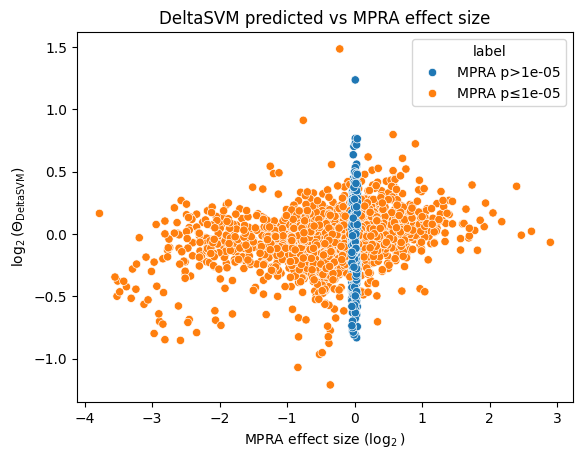

In [20]:
ax = sns.scatterplot(data=gksvm_df_roc,
                     x='mpra_max_log2effect', y='log2FC',
                     hue='label')
ax.set(xlabel='MPRA effect size ($\log_2)$', ylabel='$\log_2(\Theta_{\mathrm{DeltaSVM}})$')
ax.set_title('DeltaSVM predicted vs MPRA effect size')

### AUCc and ROC plots

In [21]:
from starrutil.roc import roc_topN

#### All regions

  AUCs:
    All data = 0.559
    Top 1000 = 0.605
    Top  500 = 0.629
    Top  200 = 0.693


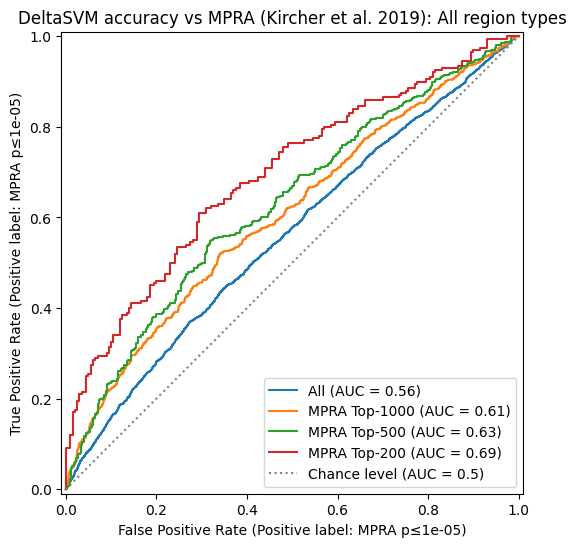

In [22]:
rocs, ax = roc_topN(gksvm_df_roc, pos_label=pos_label, neg_label=neg_label, random_state=42)
_ = ax.set_title('DeltaSVM accuracy vs MPRA (Kircher et al. 2019): All region types')

#### Enhancers and Promoters separately

Region type: Enhancers
  AUCs:
    All data = 0.568
    Top 1000 = 0.561
    Top  500 = 0.615
    Top  200 = 0.658
Region type: Promoters
  AUCs:
    All data = 0.553
    Top 1000 = 0.571
    Top  500 = 0.584
    Top  200 = 0.659


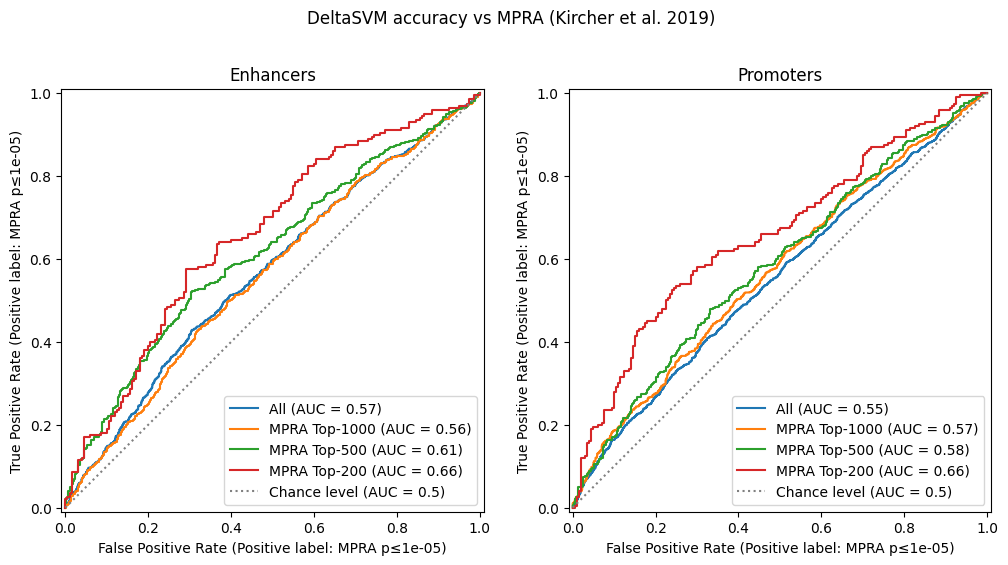

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, region_type in enumerate(['Enhancers', 'Promoters']):
    df = gksvm_df_roc.loc[gksvm_df_roc['region_type'] == region_type]
    print(f"Region type: {region_type}")
    _, ax = roc_topN(df, neg_label=neg_label, pos_label=pos_label, ax=axs[i])
    ax.set_title(f'{region_type}')
_ = fig.suptitle('DeltaSVM accuracy vs MPRA (Kircher et al. 2019)')